### Preparing data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta

In [2]:
data1 = pd.read_csv('meal.csv')
data1 = data1.dropna()

In [3]:
data2 = pd.read_sas('DR2IFF_I.XPT')
data2 = data2.dropna()

### Considering eating occasion (DR1_030Z)

In [4]:
day1 = data1[['DR1_020', 'DR1ICARB', 'DR1_030Z']].copy()
day2 = data2[['DR2_020', 'DR2ICARB', 'DR2_030Z']].copy()

In [5]:
day2.columns = ['time', 'CHO', 'occasion']
day1.columns = ['time', 'CHO', 'occasion']

In [6]:
total = pd.concat([day1, day2])

In [7]:
occasiondict = {
    1 : { 'name' : 'Breakfast\nDesayano', 'count' : 0, 'cho' : 0},
    2 : { 'name' : 'Lunch\nAlmuerzo\nCena', 'count' : 0, 'cho' : 0},
    3 : { 'name' : 'Dinner', 'count' : 0, 'cho' : 0},
    4 : { 'name' : 'Supper', 'count' : 0, 'cho' : 0},
    5 : { 'name' : 'Brunch', 'count' : 0, 'cho' : 0},
    6 : { 'name' : 'Snack\nMerienda\nBotana\nBocadillo\nTentempie', 'count' : 0, 'cho' : 0},
    7 : { 'name' : 'Drink\nBebida', 'count' : 0, 'cho' : 0},
    8 : { 'name' : 'Infant feeding', 'count' : 0, 'cho' : 0},
    9 : { 'name' : 'Extended consumption\nEntre comida', 'count' : 0, 'cho' : 0},
}

In [8]:
for row, value in total.iterrows():
    if value['occasion'] == 10:
        value['occasion'] = 1
    elif value['occasion'] == 11 or value['occasion'] == 14 or value['occasion'] == 12:
        value['occasion'] = 2
    elif value['occasion'] == 13 or value['occasion'] == 16 or value['occasion'] == 17 or value['occasion'] == 18:
        value['occasion'] = 6
    elif value['occasion'] == 19:
        value['occasion'] = 7
    elif value['occasion'] == 15:
        value['occasion'] = 9

In [9]:
for key in occasiondict.keys():
    for row, value in total.iterrows():
        if value['occasion'] == key:
            occasiondict[key]['count'] += 1
            occasiondict[key]['cho'] += value['CHO']

In [10]:
occasionnames = []
occasioncho = []
for key in occasiondict: 
    occasionnames.append(occasiondict[key]['name'])
    occasioncho.append(occasiondict[key]['cho']/occasiondict[key]['count'])

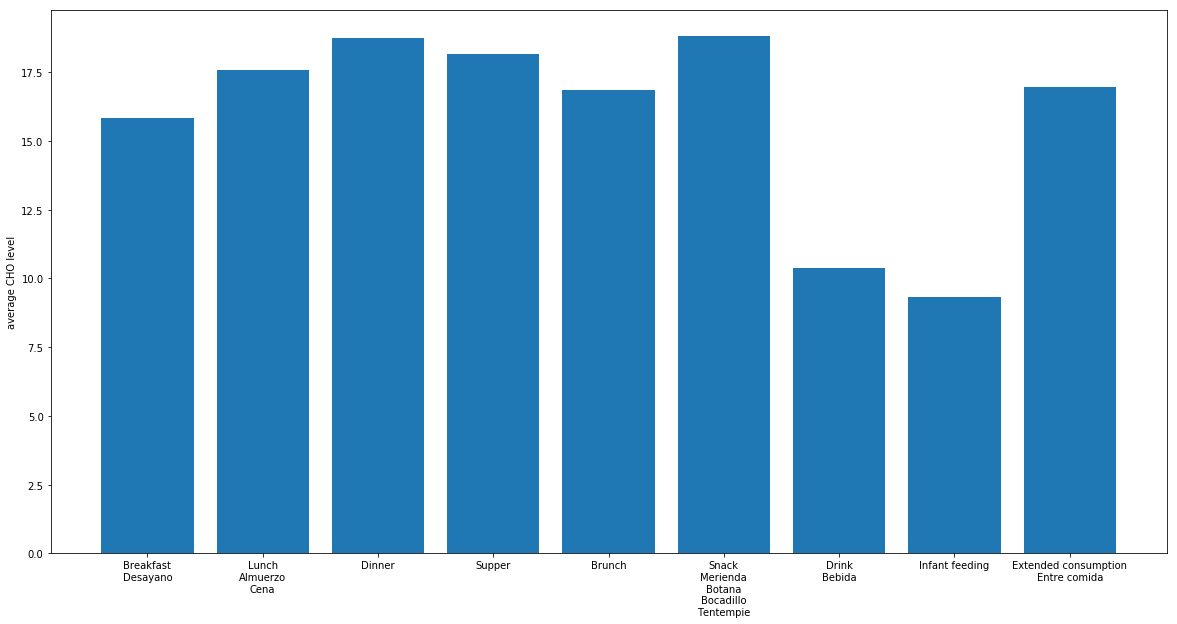

In [11]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.bar(np.arange(len(occasionnames)), occasioncho)
plt.xticks(np.arange(len(occasionnames)), occasionnames)
plt.ylabel('average CHO level')
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [12]:
occasionnames[occasioncho.index(max(occasioncho))]

'Snack\nMerienda\nBotana\nBocadillo\nTentempie'

In [13]:
occasiondict

{1: {'name': 'Breakfast\nDesayano', 'count': 42592, 'cho': 674850.9599999961},
 2: {'name': 'Lunch\nAlmuerzo\nCena',
  'count': 53509,
  'cho': 941158.9600000129},
 3: {'name': 'Dinner', 'count': 41146, 'cho': 770939.4100000007},
 4: {'name': 'Supper', 'count': 9369, 'cho': 170285.26999999955},
 5: {'name': 'Brunch', 'count': 1550, 'cho': 26124.58000000002},
 6: {'name': 'Snack\nMerienda\nBotana\nBocadillo\nTentempie',
  'count': 35190,
  'cho': 662414.2299999926},
 7: {'name': 'Drink\nBebida', 'count': 9506, 'cho': 98489.29999999961},
 8: {'name': 'Infant feeding', 'count': 4129, 'cho': 38467.91999999995},
 9: {'name': 'Extended consumption\nEntre comida',
  'count': 3541,
  'cho': 60039.62999999992}}

In [14]:
print(total['occasion'].unique())

[1. 7. 6. 2. 4. 3. 9. 5. 8.]


### Manual Clustering

In [15]:
breakfastdf = total[total['occasion'] == 1]

In [16]:
breakfastdf.shape

(42592, 3)

In [17]:
lunchdf = total[total['occasion'] == 2]

In [18]:
lunchdf.shape

(53509, 3)

In [19]:
dinnerdf = total[total['occasion'] == 3]

In [20]:
dinnerdf.shape

(41146, 3)

In [21]:
supperdf = total[total['occasion'] == 4]

In [22]:
supperdf.shape

(9369, 3)

In [23]:
brunchdf = total[total['occasion'] == 5]

In [24]:
brunchdf.shape

(1550, 3)

In [25]:
snackdf = total[total['occasion'] == 6]

In [26]:
snackdf.shape

(35190, 3)

In [27]:
drinkdf = total[total['occasion'] == 7]

In [28]:
drinkdf.shape

(9506, 3)

In [29]:
infantdf = total[total['occasion'] == 8]

In [30]:
infantdf.shape

(4129, 3)

In [31]:
extendeddf = total[total['occasion'] == 9]

In [32]:
extendeddf.shape

(3541, 3)

### Prediction

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

first_row = pd.DataFrame({'time': 0, 'CHO': 0}, index =[0])

def prepare_data(cluster_name):
    cluster_name = cluster_name.sort_values(by=['time'])
    cluster_name = cluster_name.drop(['occasion'], axis=1)
    cluster_name = pd.concat([first_row, cluster_name]).reset_index(drop = True)
    cluster_name = cluster_name.append({'time': 0, 'CHO': 0} , ignore_index=True)
    X = cluster_name[0:(len(cluster_name)-1)]
    y = cluster_name[1:(len(cluster_name))]
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
    tup = (X_train, X_test, y_train, y_test)
    return (tup)

def regression(X_train, X_test, y_train, y_test):
    lr = LinearRegression().fit(X_train,y_train)
    train_score = lr.score(X_train, y_train)*100
    test_score = lr.score(X_test, y_test)*100
    y_pred = lr.predict(X_test)
    r_score = r2_score(y_test, y_pred)*100
    tup_score = (train_score, test_score, r_score)
    return (tup_score)

#### On breakfast

In [38]:
breakfastdf

,time,CHO,occasion
0,27000.0,5.397605e-79,1.0
1,27000.0,3.560000e+00,1.0
2,27000.0,2.320000e+00,1.0
4,32400.0,4.088000e+01,1.0
5,32400.0,2.500000e-01,1.0
25,32400.0,7.200000e-01,1.0
26,32400.0,9.900000e-01,1.0
27,32400.0,5.397605e-79,1.0
28,32400.0,6.970000e+00,1.0
29,32400.0,2.612000e+01,1.0


In [39]:
tup = prepare_data(breakfastdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

(99.98606227756464, 98.00167400067522, 49.07305294199369)


In [43]:
tup[0].head()

,time,CHO
6323,25200.0,23.40
18099,28800.0,13.63
2627,21600.0,15.38
4852,24000.0,11.71
39572,37800.0,0.20


In [44]:
tup[1]

,time,CHO
36863,36000.0,7.000000e-01
33849,34200.0,9.100000e-01
25719,31500.0,2.802000e+01
39729,37800.0,6.510000e+00
28412,32400.0,4.170000e+00
10905,27000.0,7.320000e+00
21481,29700.0,1.340000e+01
40300,39600.0,2.900000e-01
6919,25200.0,5.397605e-79
10718,27000.0,6.641000e+01


#### On lunch

In [ ]:
tup = prepare_data(lunchdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On dinner

In [ ]:
tup = prepare_data(dinnerdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On supper

In [ ]:
tup = prepare_data(supperdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On brunch

In [ ]:
tup = prepare_data(brunchdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On snacks

In [ ]:
tup = prepare_data(snackdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On drinks

In [ ]:
tup = prepare_data(drinkdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On infant

In [ ]:
tup = prepare_data(infantdf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On extended

In [ ]:
tup = prepare_data(extendeddf)
tup_score = regression(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

### Considering Intake day of the week

In [ ]:
day1 = data1[['DR1_020', 'DR1ICARB', 'DR1DAY']].copy()
day2 = data2[['DR2_020', 'DR2ICARB', 'DR2DAY']].copy()

In [ ]:
day2.columns = ['time', 'CHO', 'day']
day1.columns = ['time', 'CHO', 'day']
total = pd.concat([day1, day2])
total

In [ ]:
sun = 0
mon = 0
tue = 0
wed = 0
thu = 0
fri = 0
sat = 0
sunc = 0
monc = 0
tuec = 0
wedc = 0
thuc = 0
fric = 0
satc = 0
for row, value in total.iterrows():
    if value['day'] == 1.0:
        sunc += 1
        sun = sun + value['CHO']
    if value['day'] == 2.0:
        monc += 1
        mon = mon + value['CHO']
    if value['day'] == 3.0:
        tuec += 1
        tue = tue + value['CHO']
    if value['day'] == 4.0:
        wedc += 1
        wed = wed + value['CHO']
    if value['day'] == 5.0:
        thuc += 1
        thu = thu + value['CHO']
    if value['day'] == 6.0:
        fric += 1
        fri = fri + value['CHO']
    if value['day'] == 7.0:
        satc += 1
        sat = sat + value['CHO']

In [ ]:
week1 = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']
week = [sun/sunc, mon/monc, tue/tuec, wed/wedc, thu/thuc, fri/fric, sat/satc]

In [ ]:
plt.bar(np.arange(len(week1)), week)
plt.xticks(np.arange(len(week1)), week1)
plt.ylabel('average CHO level')

In [ ]:
week1[week.index(max(week))]

In [ ]:
print(total['day'].unique())

In [ ]:
sundf = total[total['day'] == 1]

In [ ]:
mondf = total[total['day'] == 2]

In [ ]:
tuedf = total[total['day'] == 3]

In [ ]:
weddf = total[total['day'] == 4]

In [ ]:
thudf = total[total['day'] == 5]

In [ ]:
fridf = total[total['day'] == 6]

In [ ]:
satdf = total[total['day'] == 7]

#### Prediction

In [ ]:
def prepare_data1(cluster_name):
    cluster_name = cluster_name.sort_values(by=['time'])
    cluster_name = cluster_name.drop(['day'], axis=1)
    cluster_name = pd.concat([first_row, cluster_name]).reset_index(drop = True)
    cluster_name = cluster_name.append({'time': 0, 'CHO': 0} , ignore_index=True)
    X = cluster_name[0:(len(cluster_name)-1)]
    y = cluster_name[1:(len(cluster_name))]
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
    tup = (X_train, X_test, y_train, y_test)
    return (tup)

def regression1(X_train, X_test, y_train, y_test):
    lr = LinearRegression().fit(X_train,y_train)
    train_score = lr.score(X_train, y_train)*100
    test_score = lr.score(X_test, y_test)*100
    y_pred = lr.predict(X_test)
    r_score = r2_score(y_test, y_pred)*100
    tup_score = (train_score, test_score, r_score)
    return (tup_score)

#### On sunday

In [ ]:
tup = prepare_data1(sundf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On monday

In [ ]:
tup = prepare_data1(mondf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On tuesday

In [ ]:
tup = prepare_data1(tuedf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On wednesday

In [ ]:
tup = prepare_data1(weddf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On Thursday

In [ ]:
tup = prepare_data1(thudf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On Friday

In [ ]:
tup = prepare_data1(fridf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### On Saturday

In [ ]:
tup = prepare_data1(satdf)
tup_score = regression1(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

### DR1_040Z  and DR2_040Z - Did you eat this meal at home?

#### 1 - at home         2 - Not at home

In [ ]:
day1 = data1[['DR1_020', 'DR1ICARB', 'DR1_040Z']].copy()
day2 = data2[['DR2_020', 'DR2ICARB', 'DR2_040Z']].copy()
day2.columns = ['time', 'CHO', 'at_home']
day1.columns = ['time', 'CHO', 'at_home']
total = pd.concat([day1, day2])
total

In [ ]:
yes = 0
no = 0
yesc = 0
noc = 0
for row, value in total.iterrows():
    if value['at_home'] == 1.0:
        yesc += 1
        yes = yes + value['CHO']
    if value['at_home'] == 2.0:
        noc += 1
        no = no + value['CHO']

In [ ]:
plt.bar([0,1], [yes/yesc,no/noc])
plt.xticks(np.arange(2), ['at home', 'not at home'])
fig_size[0] = 1
plt.ylabel("Average CHO levels")
fig_size[1] = 1
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
print(total['at_home'].unique())

In [ ]:
mealhome = total[total['at_home'] == 1]

In [ ]:
mealhome.shape

In [ ]:
mealoutside = total[total['at_home'] == 2]

In [ ]:
mealoutside.shape

#### Prediction

In [ ]:
def prepare_data2(cluster_name):
    cluster_name = cluster_name.sort_values(by=['time'])
    cluster_name = cluster_name.drop(['at_home'], axis=1)
    cluster_name = pd.concat([first_row, cluster_name]).reset_index(drop = True)
    cluster_name = cluster_name.append({'time': 0, 'CHO': 0} , ignore_index=True)
    X = cluster_name[0:(len(cluster_name)-1)]
    y = cluster_name[1:(len(cluster_name))]
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
    tup = (X_train, X_test, y_train, y_test)
    return (tup)

def regression2(X_train, X_test, y_train, y_test):
    lr = LinearRegression().fit(X_train,y_train)
    train_score = lr.score(X_train, y_train)*100
    test_score = lr.score(X_test, y_test)*100
    y_pred = lr.predict(X_test)
    r_score = r2_score(y_test, y_pred)*100
    tup_score = (train_score, test_score, r_score)
    return (tup_score)

#### At home

In [ ]:
tup = prepare_data2(mealhome)
tup_score = regression2(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

#### Outside home

In [ ]:
tup = prepare_data2(mealoutside)
tup_score = regression2(tup[0], tup[1], tup[2], tup[3])
print(tup_score)

In [37]:
tup_score

NameError: name 'tup_score' is not defined